In [50]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns

In [51]:
#IMPORTANT : THIS IS IN EXCEL FORMAT, CHANGE TO CSV IF YOUR FILE IS NOT XLSX
df_q_list = pd.read_excel("question_data.xlsx")

In [52]:
# TAKE A SAMPLE OF DATA
filename = "user_data_public.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df_master = pd.read_csv(filename, skiprows=skip, dtype = object)

In [53]:
#Count not missing each row i.e: number of answered questions by each preson:
df_master["answered_questions"] = df_master.notnull().sum(axis=1)

In [54]:
# Take only questions with n answers and put the questions in a column
#df_q.N.plot(kind="hist")

n_answers = 20000
df_keep = pd.DataFrame()
df_keep['keep_questions'] = df_q_list[df_q_list["N"]>n_answers].index

In [55]:
#Keep only questions that are also in master dataframe
df_keep = df_keep[df_keep["keep_questions"].isin(list(df_master.columns.values))]

In [56]:
#Choose only rows with at least 1000 answered questions
df_clean_question = df_master[df_master["answered_questions"]>1000]

In [57]:
#Create new dataset with only most answered questions
df_clean_v1 = df_clean_question[list(df_keep["keep_questions"])]

In [58]:
#Create dummy for sexual orientation, where 1 = NOT STRAIGHT
sexual_orientation = []
for x in df_clean_v1['d_orientation']:
    if pd.isnull(x):
        sexual_orientation.append(1) #Since we have persons answered over a 1000 questions, so if they have not answered their sexual orientation we assume they are either uncertain or dont want to disclose because of fear of persecution/judgement from peers
    elif x != "Straight":
        sexual_orientation.append(1)
    else:
        sexual_orientation.append(0)

In [59]:
#Turn it into a dataframe and put labels from dataframe on
y = pd.DataFrame(sexual_orientation, index = df_clean_v1.index)

In [60]:
# Drop sexual orientation from master dataframe
df_clean_v1.drop(columns = ["d_orientation"], inplace = True)
print()

/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
#UNCOMMENT THIS IF YOU WANT TO SEE HOW MANY ROWS AND QUESTIONS YOU ENDED UP WITH, AND HOW MANY MISSING IN THE ROWS
#df_clean_v1.shape
#df_clean_v1.isnull().sum(axis=1)

In [62]:
#Remove the most problematic questions, and them make all of the categorical variables dummiew
df_prep = df_clean_v1.drop(columns = ["q1401", "q80928", "q546", "q1040"])
df_dummy = pd.get_dummies(df_prep, dummy_na = False) #When missing giver 0 to all dummies created for the quesion with the missing value
#df_dummy.fillna(value = -1, inplace = True) #If missing insert -1 # This code does not work
X = df_dummy

In [63]:
#INSERT MISSING VALUES BACK INTO THE DUMMIES FOR LATER IMPUTER
for i in list(df_keep["keep_questions"].head()):
    X.loc[df_prep[i].isnull(), X.columns.str.startswith(i+"_")] = np.nan

In [67]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [69]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

im = Imputer()
X_train = im.fit_transform(X_train)
X_test = im.fit_transform(X_test)
X_dev = im.fit_transform(X_dev)
X_val = im.fit_transform(X_val)

from sklearn.linear_model import Lasso, LinearRegression
pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso())
pipe_lasso.fit(X_dev,y_dev)
pipe_lasso.predict(X_val)

KeyboardInterrupt: 

In [46]:
# THIS IS A TEST USING A DECISION TREE

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
tree = DecisionTreeClassifier(criterion='gini', max_depth= 4, random_state=1)

#IMPUTER REPLACE MISSINGS WITH THE MEAN OF THE COLUMN
im = Imputer()
X_train = im.fit_transform(X_train)
X_test = im.fit_transform(X_test)

# FIT AND PREDICT THE TREE
tree.fit(X_train, y_train)
predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict)) #This shows the accuracy of our decision tree
print(y_test.mean()) #This shows how many not straight rows in the dataset
print(mse(predict, y_test))

0.932893289329
0    0.157316
dtype: float64
0.0671067106711


In [77]:
tree.predict_proba(X_test)

array([[ 0.98781478,  0.01218522],
       [ 0.98781478,  0.01218522],
       [ 0.98781478,  0.01218522],
       ..., 
       [ 0.        ,  1.        ],
       [ 0.99747475,  0.00252525],
       [ 0.98781478,  0.01218522]])

In [78]:
# THIS IS A TEST USING A DECISION TREE

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

for i in ["entropy", "gini"]:
    errors_i = []
    accuracy_i = []
    for x in range(1,11):

        tree = DecisionTreeClassifier(criterion=i, max_depth= x, random_state=1)

        #IMPUTER REPLACE MISSINGS WITH THE MEAN OF THE COLUMN
        im = Imputer()
        X_train = im.fit_transform(X_train)
        X_test = im.transform(X_test)

        # FIT AND PREDICT THE TREE
        tree.fit(X_train, y_train)
        predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
        accuracy_i.append(accuracy_score(y_test, predict)) #This shows the accuracy of our decision tree #This shows how many not straight rows in the dataset
        errors_i.append(mse(predict, y_test)**(1/2))

In [73]:
predict

,0
4476,0
9181,0
3532,0
4020,0
4023,0
8971,0
4066,0
3874,0
1675,0
9652,0


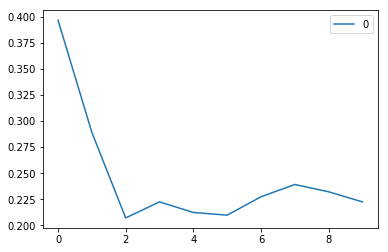

In [45]:
pd.DataFrame(errors).plot()

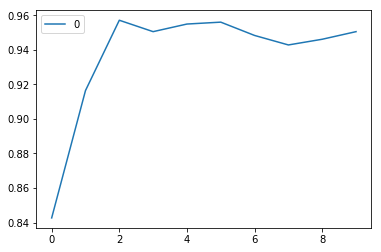

In [34]:
pd.DataFrame(accuracy).plot()